In [4]:
import numpy as np
import numba
import matplotlib.pyplot as plt
import sympy as sym
plt.style.use('presentation.mplstyle')
%matplotlib notebook

def d2np(d):
    
    names = []
    numbers = ()
    dtypes = []
    for item in d:
        names += item   
        if type(d[item]) == float:
            numbers += (d[item],)
            dtypes += [(item,float)]
        if type(d[item]) == int:
            numbers += (d[item],)
            dtypes += [(item,int)]
        if type(d[item]) == np.ndarray:
            numbers += (d[item],)
            dtypes += [(item,np.float64,d[item].shape)]
    return np.array([numbers],dtype=dtypes)

In [5]:
i_1d,i_1q,i_2d,i_2q = sym.symbols('i_1d,i_1q,i_2d,i_2q')  
di_1d,di_1q,di_2d,di_2q = sym.symbols('di_1d,di_1q,di_2d,di_2q')  
L_1,L_2,C_dc = sym.symbols('L_1,L_2,C_dc')  
R_1,R_2 = sym.symbols('R_1,R_2') 
omega_1,omega_2 = sym.symbols('omega_1,omega_2') 
v_1d,v_1q,v_2d,v_2q, v_dc= sym.symbols('v_1d,v_1q,v_2d,v_2q,v_dc') 
eta_1d,eta_1q,eta_2d,eta_2q = sym.symbols('eta_1d,eta_1q,eta_2d,eta_2q') 
p_1,q_1 = sym.symbols('p_1,q_1') 


i_dc_1 = 3.0/4.0*(eta_1d*i_1d + eta_1q*i_1q)
i_dc_2 = 3.0/4.0*(eta_2d*i_2d + eta_2q*i_2q)

di_1d = 0.5*eta_1d*v_dc - R_1*i_1d + omega_1*i_1q - v_1d
di_1q = 0.5*eta_1q*v_dc - R_1*i_1q - omega_1*i_1d - v_1q
di_2d = 0.5*eta_2d*v_dc - R_2*i_2d + omega_2*i_2q - v_2d
di_2q = 0.5*eta_2q*v_dc - R_2*i_2q - omega_2*i_2d - v_2q
dv_dc = 1.0/C_dc*(-i_dc_1 - i_dc_2)

'''    
'''

s = sym.solve([ di_1d,  di_1q,  di_2d,  di_2q],
              [eta_1d, eta_1q, eta_2d, eta_2q])



for item in s:
    print(item, '=', sym.simplify(s[item]))

eta_1d = 2.0*(R_1*i_1d - i_1q*omega_1 + v_1d)/v_dc
eta_1q = 2.0*(R_1*i_1q + i_1d*omega_1 + v_1q)/v_dc
eta_2d = 2.0*(R_2*i_2d - i_2q*omega_2 + v_2d)/v_dc
eta_2q = 2.0*(R_2*i_2q + i_2d*omega_2 + v_2q)/v_dc


In [6]:
eq_p = p_1 - 3.0/2.0*(v_1d*i_1d + v_1q*i_1q)
eq_q = q_1 - 3.0/2.0*(v_1d*i_1q - v_1q*i_1d)

s = sym.solve([ eq_p,  eq_q],
              [i_1d,   i_1q])


for item in s:
    print(item, '=', sym.simplify(s[item]))

i_1d = 0.666666666666667*(p_1*v_1d - q_1*v_1q)/(v_1d**2 + v_1q**2)
i_1q = 0.666666666666667*(p_1*v_1q + q_1*v_1d)/(v_1d**2 + v_1q**2)


In [7]:
s

{i_1d: 0.666666666666667*(p_1*v_1d - q_1*v_1q)/(v_1d**2 + v_1q**2),
 i_1q: 0.666666666666667*(p_1*v_1q + q_1*v_1d)/(v_1d**2 + v_1q**2)}

In [8]:

@numba.jit(nopython=True, cache=True)
def b2b_ctrl1(struct,i,m):
    '''
    Doubly Fed Induction Machine in with neglected dynamics and
    rotor side converter and control level 1 already implemented.
    i_rd = i_rd_ref and i_rq = i_rq_ref without dynamics 
    '''

    x_idx = struct[i]['b2b_idx']
    v_dc = float(struct[i]['x'][x_idx+0,0])
    
    L_1 = struct[i]['L_1']
    L_2 = struct[i]['L_2']
    R_1 = struct[i]['R_1']
    R_2 = struct[i]['R_2']
    C_dc = struct[i]['C_dc']

    omega_1 = struct[i]['omega_1']
    omega_2 = struct[i]['omega_2']
       
    i_1d_ref = struct[i]['i_1d_ref'] 
    i_1q_ref = struct[i]['i_1q_ref'] 
    i_2d_ref = struct[i]['i_2d_ref'] 
    i_2q_ref = struct[i]['i_2q_ref'] 
    
    i_1d = i_1d_ref
    i_1q = i_1q_ref
    i_2d = i_2d_ref
    i_2q = i_2q_ref
    
    v_1d = struct[i]['v_1d']
    v_1q = struct[i]['v_1q']
    v_2d = struct[i]['v_2d']
    v_2q = struct[i]['v_2q']
    
    
    eta_1d = 2.0*(R_1*i_1d - L_1*i_1q*omega_1 + v_1d)/v_dc
    eta_1q = 2.0*(R_1*i_1q + L_1*i_1d*omega_1 + v_1q)/v_dc
    eta_2d = 2.0*(R_2*i_2d - L_2*i_2q*omega_2 + v_2d)/v_dc
    eta_2q = 2.0*(R_2*i_2q + L_2*i_2d*omega_2 + v_2q)/v_dc
    
    i_dc_1 = 3.0/4.0*(eta_1d*i_1d + eta_1q*i_1q)
    i_dc_2 = 3.0/4.0*(eta_2d*i_2d + eta_2q*i_2q)    
    dv_dc = 1.0/C_dc*(-i_dc_1 - i_dc_2)
    
    struct[i]['eta_1d'] = eta_1d
    struct[i]['eta_1q'] = eta_1q
    struct[i]['eta_2d'] = eta_2d
    struct[i]['eta_2q'] = eta_2q
    struct[i]['i_dc_1'] = i_dc_1
    struct[i]['i_dc_2'] = i_dc_2
    
    struct[i]['p_1'] = 3.0/2.0*(v_1d*i_1d + v_1q*i_1q)
    struct[i]['q_1'] = 3.0/2.0*(v_1d*i_1q - v_1q*i_1d)

    struct[i]['p_2'] = 3.0/2.0*(v_2d*i_2d + v_2q*i_2q)
    struct[i]['q_2'] = 3.0/2.0*(v_2d*i_2q - v_2q*i_2d)
    
    struct[i]['f'][x_idx+0,0] = dv_dc
    
    return 0


In [9]:
@numba.jit(nopython=True, cache=True)
def b2b_ctrl2(struct,i,m):
    '''
    Control level 2 for DC Voltage
    
    '''
    
    x_idx = struct[i]['b2b_ctrl_idx']
    xi_v_dc = float(struct[i]['x'][x_idx+0,0]) 

    S_b = struct[i]['S_b']
    V_dc_b = struct[i]['V_dc_b']
    
    K_v_p = struct[i]['K_v_p']
    K_v_i = struct[i]['K_v_i']  

    v_dc = struct[i]['v_dc']
        
    v_dc_ref = struct[i]['v_dc_ref']
    p_1_ref = struct[i]['p_1_ref']
    q_1_ref = struct[i]['q_1_ref']  
    p_2_ref = struct[i]['p_2_ref']
    q_2_ref = struct[i]['q_2_ref']  

    v_1d = struct[i]['v_1d']
    v_1q = struct[i]['v_1q']
    v_2d = struct[i]['v_2d']
    v_2q = struct[i]['v_2q']
    
    error_v_dc = (v_dc - v_dc_ref)/V_dc_b
    
    p_ref = (K_v_p * error_v_dc + K_v_i*xi_v_dc)*S_b
    
    if struct[i]['vdc_ctrl'] == 1:
        p_ref_1 = p_ref

    if struct[i]['vdc_ctrl'] == 2:
        p_ref_2 = p_ref
        
    den = (v_1d**2 + v_1q**2)
    
    den_1 = 0.001
    if den_1 > 0.0:
        den_1 = (v_1d**2 + v_1q**2)

    den_2 = 0.001
    if den_2 > 0.0:
        den_2 = (v_2d**2 + v_2q**2)
        
    i_1d_ref = 2.0/3.0*(p_1_ref*v_1d - q_1_ref*v_1q)/den_1
    i_1q_ref = 2.0/3.0*(p_1_ref*v_1q + q_1_ref*v_1d)/den_1
    
    i_2d_ref = 2.0/3.0*(p_2_ref*v_2d - q_2_ref*v_1q)/den_2
    i_2q_ref = 2.0/3.0*(p_2_ref*v_2q + q_2_ref*v_1d)/den_2
    
    struct[i]['i_1d_ref'] = i_1d_ref
    struct[i]['i_1q_ref'] = i_1q_ref
    struct[i]['i_2d_ref'] = i_2d_ref
    struct[i]['i_2q_ref'] = i_2q_ref
   
    dxi_v_dc = error_v_dc
   
    struct[i]['f'][x_idx+0,0] = dxi_v_dc
 
    return 0


In [10]:
R_1 = R_2 = 0.1
L_1 = L_2 = 0.5e-3
Omega_b = 2.0*np.pi*50.0
C_dc = 2200.0e-6
omega_1 = omega_2 = Omega_b

d =dict(R_1 = R_1,
        R_2 = R_2,
        L_1 = L_1,
        L_2 = L_2,
        C_dc = C_dc,
        b2b_idx = 0,
        b2b_ctrl_idx = 1,
        v_dc = 800.0,
        omega_1 = omega_1,
        omega_2 = omega_2,       
        i_1d_ref = 0.0,
        i_1q_ref = 100.0, 
        i_2d_ref = 0.0, 
        i_2q_ref = -100.0, 
        i_dc_1 = 0.0,
        i_dc_2 = 0.0,
        eta_1d = 0.0,
        eta_1q = 0.0, 
        eta_2d = 0.0, 
        eta_2q = 0.0, 
        v_1d = 0.0,
        v_1q = 325.0,
        v_2d = 0.0,
        v_2q = 325.0,
        p_1 = 0.0,
        q_1 = 0.0,
        p_2 = 0.0,
        q_2 = 0.0, 
        x_idx = 0,
        xi_v_dc = 0.0, 
        S_b = 0.5e6,
        V_dc_b = 800.0,
        K_v_p = 0.1,
        K_v_i = 0.0,  
        v_dc_ref = 750.0,
        p_1_ref = 0.0,
        q_1_ref = 0.0,
        p_2_ref = 0.0,
        q_2_ref = 0.0,
        vdc_ctrl = 1,
        x = np.array([[800.0],[0.0]]),
        f = np.array([[0.0],[0.0]])      
        )








struct = d2np(d)

i=0
m=2
b2b_ctrl1(struct,i,m)
b2b_ctrl2(struct,i,m)
print(struct[i]['p_1'])
print(struct[i]['p_2'])
print(struct[i]['i_dc_1'])
print(struct[i]['i_dc_2'])
print(struct[i]['f'])

48750.0
-48750.0
62.8125
-59.0625
[[ -1.70454545e+03]
 [  6.25000000e-02]]


In [11]:
struct = d2np(d)

sys_d = dict(x = np.array([[800.0],[0.0]]),
             f = np.zeros((2,1)))

sys_struct = d2np(sys_d)

@numba.jit(nopython=True, cache=True)
def f_eval(sys_struct,struct):
    N_states = 2
    for i in range(1):
        struct[i]['x'][:,0] = sys_struct[0]['x'][N_states*i:N_states*(i+1),0]
        b2b_ctrl1(struct,i,m)
        b2b_ctrl2(struct,i,m)
        sys_struct[0]['f'][N_states*i:N_states*(i+1),:] = struct[i]['f']
    return 0


In [12]:
@numba.jit(nopython=True, cache=True)
def run(sys_struct,struct):  
    N_steps = 1000
    N_states = 2

    Dt = 10.0e-3
    Omega_r = np.zeros((N_steps,1))
    Omega_t = np.zeros((N_steps,1))
    P_1 = np.zeros((N_steps,1))
    Q_1 = np.zeros((N_steps,1))
    P_2 = np.zeros((N_steps,1))
    Q_2 = np.zeros((N_steps,1))
    V_dr = np.zeros((N_steps,1))
    V_qr = np.zeros((N_steps,1))
    I_dr = np.zeros((N_steps,1))
    I_qr = np.zeros((N_steps,1))
    Tau_e = np.zeros((N_steps,1))
    T     = np.zeros((N_steps,1))
    X = np.zeros((N_steps,N_states))

    V_dc = np.zeros((N_steps,1))
    p_ref = 0.0
    q_ref = 0.0    
    xi_p = 0.0
    xi_q = 0.0
    
    struct[0]['x'][:,0] = np.copy(sys_struct[0]['x'][0:2,0])
    
    for it in range(N_steps):
        t = Dt*float(it)
 
        # perturbations and references

        struct[0]['p_1_ref'] = 0.0
        struct[0]['p_2_ref'] = 0.0
        struct[0]['q_1_ref'] = 0.0
        struct[0]['q_2_ref'] = 0.0  
            
        if t>2.0:
            struct[0]['p_1_ref'] = 1.0e6
        if t>3.0:
            struct[0]['p_2_ref'] = 0.1e6
          
        ## solver   

        f_eval(sys_struct,struct)
        f1 = np.copy(sys_struct[0]['f'])
        x1 = np.copy(sys_struct[0]['x'])
        
        sys_struct[0]['x'][:]= np.copy(x1 + Dt*f1)
        f_eval(sys_struct,struct)
        f2 = np.copy(sys_struct[0]['f'])
        
        sys_struct[0]['x'][:]= np.copy(x1 + 0.5*Dt*(f1 + f2))        

        for i in range(1):
            struct[i]['x'][:,0] = sys_struct[0]['x'][2*i:2*(i+1),0]

               
        T[it,0] = t
        V_dc[it,0] = float(struct[0]['v_dc'])
        X[it,:] = sys_struct[0]['x'][:].T
    return T,X,V_dc
%timeit run(sys_struct, struct)

743 µs ± 172 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
run(sys_struct, struct)

(array([[ 0.  ],
        [ 0.01],
        [ 0.02],
        [ 0.03],
        [ 0.04],
        [ 0.05],
        [ 0.06],
        [ 0.07],
        [ 0.08],
        [ 0.09],
        [ 0.1 ],
        [ 0.11],
        [ 0.12],
        [ 0.13],
        [ 0.14],
        [ 0.15],
        [ 0.16],
        [ 0.17],
        [ 0.18],
        [ 0.19],
        [ 0.2 ],
        [ 0.21],
        [ 0.22],
        [ 0.23],
        [ 0.24],
        [ 0.25],
        [ 0.26],
        [ 0.27],
        [ 0.28],
        [ 0.29],
        [ 0.3 ],
        [ 0.31],
        [ 0.32],
        [ 0.33],
        [ 0.34],
        [ 0.35],
        [ 0.36],
        [ 0.37],
        [ 0.38],
        [ 0.39],
        [ 0.4 ],
        [ 0.41],
        [ 0.42],
        [ 0.43],
        [ 0.44],
        [ 0.45],
        [ 0.46],
        [ 0.47],
        [ 0.48],
        [ 0.49],
        [ 0.5 ],
        [ 0.51],
        [ 0.52],
        [ 0.53],
        [ 0.54],
        [ 0.55],
        [ 0.56],
        [ 0.57],
        [ 0.58

In [14]:
sys_struct['x'][:]= np.zeros((6,1))
struct['v_qs'] = 0.0
struct['v_ds'] = 690.0*np.sqrt(2.0/3.0)
struct['tau_t'] = 0.0
sys_struct[0]['x'][0,0] = Omega_b*0.9/struct[0]['N_tr']/struct[0]['N_pp']
sys_struct[0]['x'][3,0] = Omega_b*1.1/struct[1]['N_tr']/struct[0]['N_pp']
T,X,Tau_e,P_s_1,Q_s_1,P_r_1,Q_r_1,P_s_2,Q_s_2,P_r_2,Q_r_2,V_dr,V_qr,Omega_r,Omega_t,I_dr,I_qr = run(sys_struct, struct)

ValueError: could not broadcast input array from shape (6,1) into shape (1,2,1)

<IPython.core.display.Javascript object>


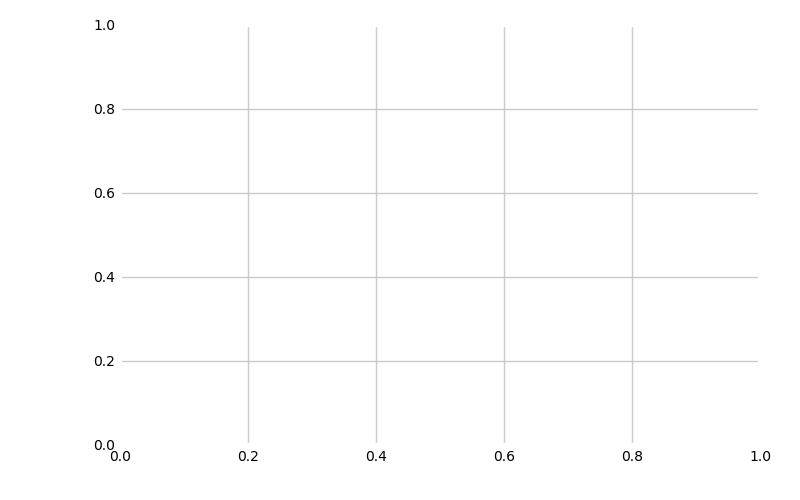

NameError: name 'T' is not defined

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 5), sharex = True)
axes.plot(T,Tau_e)
fig.savefig('dfim_tau_e.svg', bbox_inches='tight')

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8), sharex = True)
axes[0].plot(T,P_s_1/1e6, label='$\sf p_{s1}$')
axes[0].plot(T,Q_s_1/1e6, label='$\sf q_{s1}$')
axes[0].plot(T,P_s_2/1e6, label='$\sf p_{s2}$')
axes[0].plot(T,Q_s_2/1e6, label='$\sf q_{s2}$')

axes[1].plot(T,P_r_1/1e6, label='$\sf p_{r1}$')
axes[1].plot(T,Q_r_1/1e6, label='$\sf q_{r1}$')
axes[1].plot(T,P_r_2/1e6, label='$\sf p_{r2}$')
axes[1].plot(T,Q_r_2/1e6, label='$\sf q_{r2}$')

axes[0].legend()
axes[1].legend()
fig.savefig('dfim_tau_e.svg', bbox_inches='tight')


<IPython.core.display.Javascript object>

NameError: name 'T' is not defined

<IPython.core.display.Javascript object>


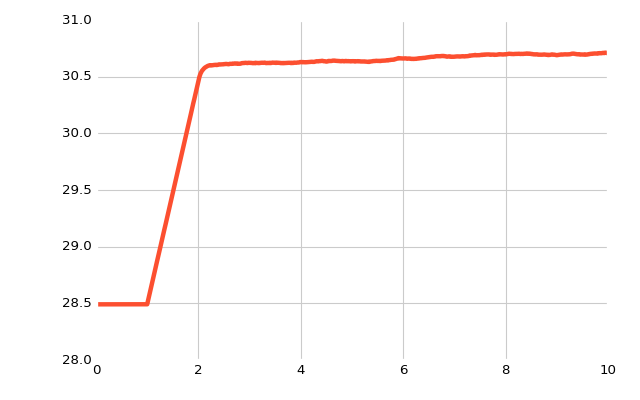

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 5), sharex = True)
axes.plot(T,Omega_t)

<IPython.core.display.Javascript object>


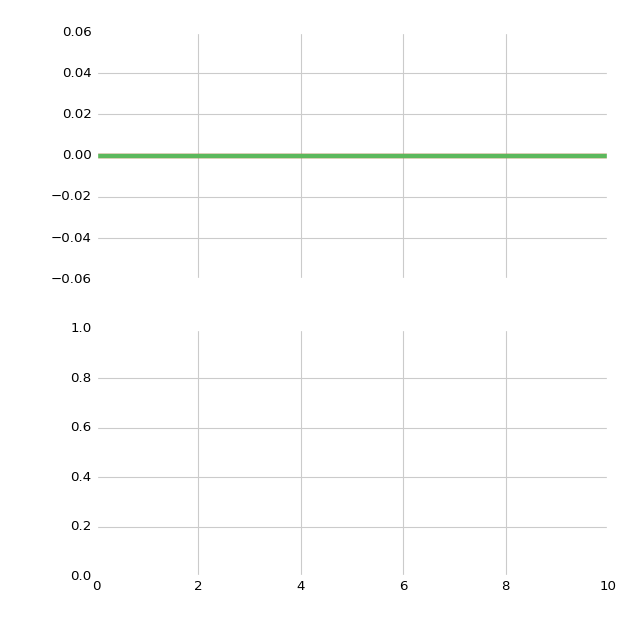

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8), sharex = True)
axes[0].plot(T,V_dr, label='$\sf v_{dr}$')
axes[0].plot(T,V_qr, label='$\sf v_{qr}$')

<IPython.core.display.Javascript object>


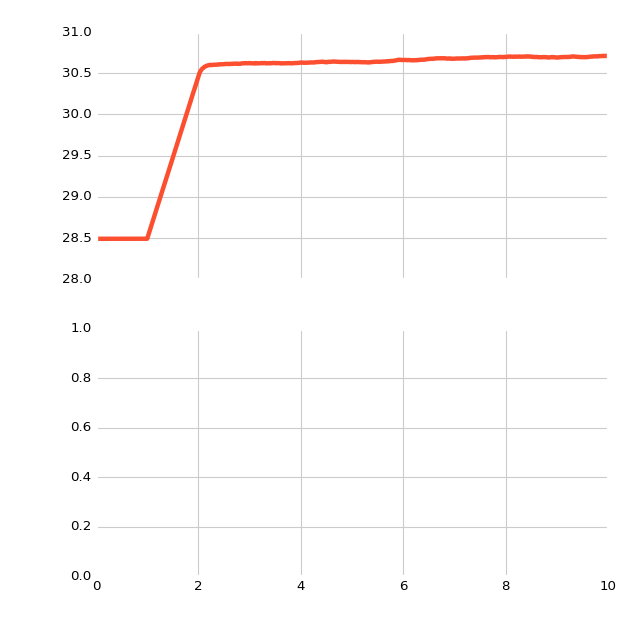

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8), sharex = True)
axes[0].plot(T,Omega_t, label='$\sf v_{dr}$')


In [14]:
Omega_t[0]

array([ 28.49112481])

<IPython.core.display.Javascript object>


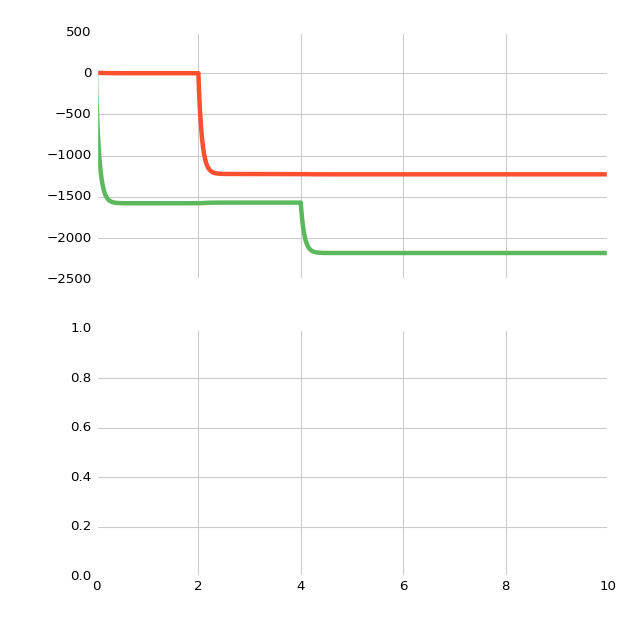

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8), sharex = True)
axes[0].plot(T,I_dr, label='$\sf i_{dr}$')
axes[0].plot(T,I_qr, label='$\sf i_{qr}$')

<IPython.core.display.Javascript object>


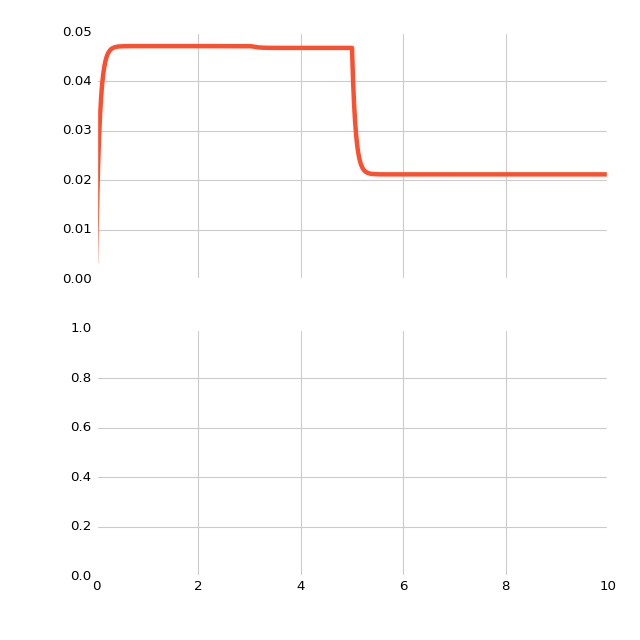

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8), sharex = True)
axes[0].plot(T,X[:,5], label='$\sf x$')


In [18]:
np.random.normal(500e3,100e3)

544736.9086734804